### Modules

In [136]:
import sys
import pandas as pd
import requests
import pprint
from requests_toolbelt.threaded import pool
import matplotlib.pyplot as plt
from pywaffle import Waffle
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np



### Data Extraction

In [ ]:
LASTFM_API_KEY = input("api key")
LASTFM_USER_NAME =input("user_name")
TEXT = "#text"
ESTIMATED_TIME_FOR_PROCESSING_PAGE = 352
ESTIMATED_TIME_FOR_PROCESSING_DATAFRAME_PER_PAGE_OF_RESULTS = 275

def get_scrobbles(
    endpoint="recenttracks",
    username=LASTFM_USER_NAME,
    key=LASTFM_API_KEY,
    limit=200,
    extended=0,
    page=1,
    pages=0,
):
    url = (
        "https://ws.audioscrobbler.com/2.0/?method=user.get{}"
        "&user={}"
        "&api_key={}"
        "&limit={}"
        "&extended={}"
        "&page={}"
        "&format=json"
    )
    
    request_url = url.format(endpoint, username, key, limit, extended, page)
    response = requests.get(request_url).json()
    total_pages = int(response[endpoint]["@attr"]["totalPages"])
    if pages > 0:
        total_pages = min([total_pages, pages])

    print(
        "Total pages to retrieve: {}. Estimated time: {}".format(
            total_pages, get_time_remaining(total_pages)
        )
    )

    artist_names = []
    album_names = []
    track_names = []
    timestamps = []
    urls = []
    
    for page in range(0, int(total_pages) + 1, 1):
        urls.append(url.format(endpoint, username, key, limit, extended, page))
    p = pool.Pool.from_urls(urls)
    p.join_all()

    for response in p.responses():
        if endpoint in response.json():
            response_json = response.json()[endpoint]["track"]
            for track in response_json:
                if "@attr" not in track:
                    artist_names.append(track["artist"][TEXT])
                    album_names.append(track["album"][TEXT])
                    track_names.append(track["name"])
                    timestamps.append(track["date"]["uts"])
    df = pd.DataFrame()
    df["artist"] = artist_names
    df["album"] = album_names
    df["track"] = track_names
    df["timestamps"] = timestamps
    df["datetime"] = pd.to_datetime(timestamps, unit="s")
    df.sort_values("timestamps", ascending=False, inplace=True)
    return df

# Remaining time
def get_time_remaining(pages_remaining):
    millis_remaining = int(
        (pages_remaining * ESTIMATED_TIME_FOR_PROCESSING_PAGE)
        + (
            pages_remaining
            * ESTIMATED_TIME_FOR_PROCESSING_DATAFRAME_PER_PAGE_OF_RESULTS
        )
    )
    seconds_remaining = (millis_remaining / 1000) % 60
    seconds_remaining = int(seconds_remaining)
    minutes_remaining = (millis_remaining / (1000 * 60)) % 60
    minutes_remaining = int(minutes_remaining)
    return "{}m{:2}s".format(minutes_remaining, seconds_remaining)


scrobbles = get_scrobbles(page=1, pages=0)  # Default to all Scrobbles
scrobbles.to_csv("lastfm_scrobbles.csv", index=False, encoding="utf-8")
print("{:,} total rows".format(len(scrobbles)))
scrobbles.head()



In [ ]:

df=scrobbles[["artist"]]
df["scrobbles"] = df.groupby("artist")["artist"].transform("count")
dfscrob=df.drop_duplicates()
dfscrob=dfscrob.sort_values(by="scrobbles", ascending=False)
dfscrobandartsits=dfscrob
dfscrob=dfscrob["artist"]
dfscrob=dfscrob.tolist()

In [ ]:
allgenres=[]
def artist_genre(artist_names,LASTFM_API_KEY):
    for i in range(0,len(artist_names)):
        artist=artist_names[i]
        url = f'http://ws.audioscrobbler.com/2.0/?method=artist.getinfo&artist={artist}&api_key={LASTFM_API_KEY}&format=json'
        response = requests.get(url)
        data = response.json()
        genres = data['artist']['tags']['tag']
        genre_list = [genre['name'] for genre in genres]
        allgenres.append(genre_list)
    return allgenres
        
###DOMi & JD Beck causes error in 'artist' search of 8th line. Therefore only 174 artists were taken for now.
#print(dfscrob[170:175])
#print(dfscrob[173])
# dfscrob[173]= "DOMi+&+JD+Beck"

artist_genre(dfscrob[0:173], LASTFM_API_KEY)


In [ ]:
genredf=pd.DataFrame(allgenres, columns=["1st_genre","2nd_genre","3rd_genre","4th_genre","5th_genre"])
genredf.insert(0,column="artist",value=dfscrob[0:173])
numbers=dfscrobandartsits["scrobbles"].tolist()
genredf.insert(2,column="scrobbles",value=numbers[0:173])


In [ ]:
genredf[["1st_genre","scrobbles"]]
genredf["scrobbles"]=genredf["scrobbles"]
genredf=genredf[["1st_genre","scrobbles"]].drop_duplicates()

merge_genredf=genredf.groupby("1st_genre").sum().reset_index()
dic_genredf=pd.Series(merge_genredf["scrobbles"].values,index=merge_genredf["1st_genre"]).to_dict()
print(dic_genredf)

###  Graphs

#### Waffle Chart

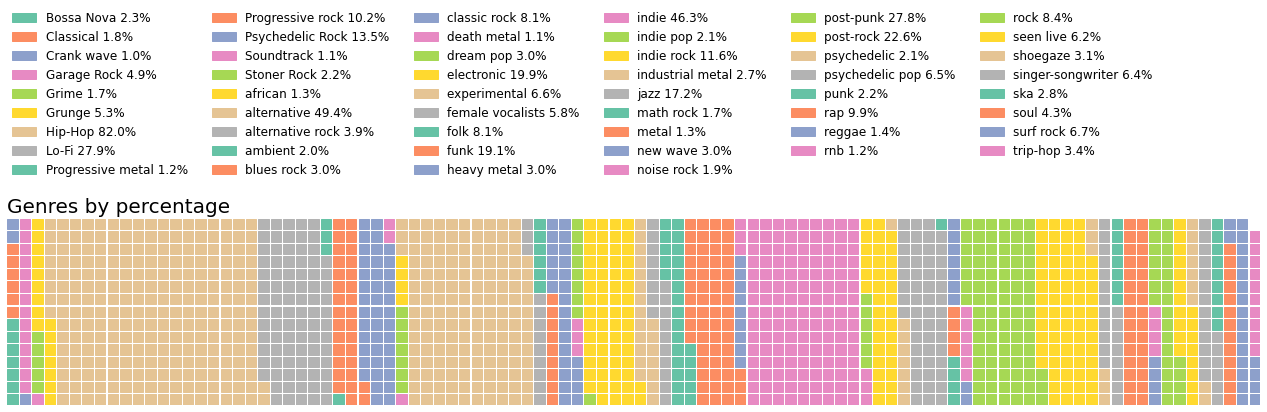

In [206]:
labels = [f'{k} {v/100:.1f}%' for k,v in dic_genredf.items()]
# v is divided by 100 to normalize the data
fig = plt.figure(FigureClass=Waffle,
                 figsize=(18,8),
                 rows=15,
                 columns=100,
                 values=dic_genredf,
                 title={'label': 'Genres by percentage', 'loc': 'left', 'fontdict': {'fontsize': 20}},
                 legend={'loc': (0, 1.2), 'ncol': 6, 'fontsize': 12, 'framealpha': 0, "labels" :labels})